In [2]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [3]:
# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, _), (X_test, _) = mnist.load_data()

mnist_digits = np.concatenate([X_train, X_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [4]:
# Set the dimensions of the noise
latent_dim = 128
usePreTrainVae = False

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [6]:
#VAE ENCODER
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 5, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     51264       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 128)    204928      conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
#VAE DECODER
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 5, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 5, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 5, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        204864    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        51232     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         801 

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [9]:
plot_model(encoder, to_file='vae_encoder.png', show_shapes=True);
plot_model(decoder, to_file='vae_decoder.png', show_shapes=True);

In [10]:
if usePreTrainVae:
  # vae.load_weights(args.weights)
  encoder.load_weights('vae_encoder_mnist.h5')
  decoder.load_weights('vae_decoder_mnist.h5')
else:
    # train the autoencoder
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(mnist_digits, epochs=90, batch_size=512)
    #save models
    encoder.save_weights('vae_encoder_mnist.h5')
    decoder.save_weights('vae_decoder_mnist.h5')

Epoch 1/90
137/137 [==============================] - 13s 93ms/step - loss: 193.3087 - reconstruction_loss: 192.1700 - kl_loss: 1.1387
Epoch 2/90
137/137 [==============================] - 12s 90ms/step - loss: 87.9172 - reconstruction_loss: 85.4947 - kl_loss: 2.4225
Epoch 3/90
137/137 [==============================] - 12s 91ms/step - loss: 69.3972 - reconstruction_loss: 66.8514 - kl_loss: 2.5458
Epoch 4/90
137/137 [==============================] - 12s 89ms/step - loss: 64.5769 - reconstruction_loss: 62.0239 - kl_loss: 2.5531
Epoch 5/90
137/137 [==============================] - 12s 88ms/step - loss: 62.0478 - reconstruction_loss: 59.4923 - kl_loss: 2.5554
Epoch 6/90
137/137 [==============================] - 12s 87ms/step - loss: 60.4575 - reconstruction_loss: 57.9097 - kl_loss: 2.5477
Epoch 7/90
137/137 [==============================] - 12s 87ms/step - loss: 59.1819 - reconstruction_loss: 56.6389 - kl_loss: 2.5430
Epoch 8/90
137/137 [==============================] - 12s 88ms/step

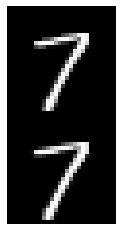

In [11]:
#test VAE
first_image = mnist_digits[2048]
first_image = first_image.reshape(1,28,28,1)

noise = np.random.normal(0, 1, size=(1, latent_dim))
z_p = encoder.predict(([first_image]))[2]

x_p = decoder.predict(z_p)
inputAdnOutput =[first_image, x_p] 

first_image = np.array(inputAdnOutput, dtype='float')
pixels = first_image.reshape((28 * 2 , 28))
plt.imshow(pixels, cmap='gray')
plt.axis('off')
plt.show()

In [12]:
# Generator NETWORK

adam = Adam(lr=0.0002, beta_1=0.5)

generator_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(1024, activation="relu")(generator_inputs)
x = BatchNormalization()(x)
x = layers.Dense(6272, activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 5, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
generator_outputs = layers.Conv2DTranspose(1, 5, activation="sigmoid", strides=2, padding="same")(x)



generator = keras.Model(generator_inputs, generator_outputs, name="generator")
generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       40

In [13]:
# Discriminator NETWORK

adam = Adam(lr=0.0002, beta_1=0.5)

discriminator_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(11, 5, strides=2, padding="same")(discriminator_inputs)
x = LeakyReLU(alpha=0.3)(x)
x = layers.Conv2D(74, 5, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(1024)(x)
x = LeakyReLU(alpha=0.3)(x)
x = BatchNormalization()(x)
discriminator_outputs = layers.Dense(1, activation="sigmoid")(x)



discriminator = keras.Model(discriminator_inputs, discriminator_outputs, name="discriminator")
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
discriminator.trainable = False

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 11)        286       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 11)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 74)          20424     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 74)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 74)          296       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3626)            

In [14]:
inputs = Input(shape=(latent_dim, ))
hidden = generator(inputs)
output = discriminator(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [15]:
plot_model(generator, to_file='gan_generator.png', show_shapes=True);
plot_model(discriminator, to_file='gan_discriminator.png', show_shapes=True);

In [16]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, latent_dim))
    x_p = decoder.predict(noise)
    z_p = encoder.predict(x_p)[2]
    generated_images = generator.predict(z_p)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = mnist_digits[np.random.randint(0, mnist_digits.shape[0], size=BATCH_SIZE)]


            # image_batch = image_batch.reshape(128, 784) #why TODO
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, latent_dim))

            #z => vae decoder
            x_p = decoder.predict(noise)
            z_p = encoder.predict(x_p)[2]

            
            # Generate the images from the noise
            generated_images = generator.predict(z_p)
            X = np.concatenate((image_batch, generated_images))

            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y)

            # Train generator
            # noise = np.random.normal(0, 1, size=(BATCH_SIZE, latent_dim))
            #z => vae decoder
            # x_p = decoder.predict(noise)
            # z_p = encoder.predict(x_p)[2]


            y2 = np.ones(BATCH_SIZE)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(z_p, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 400
Batch size: 512
Batches per epoch: 117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


--------------- Epoch 1 ---------------


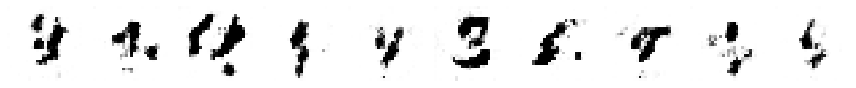

--------------- Epoch 20 ---------------


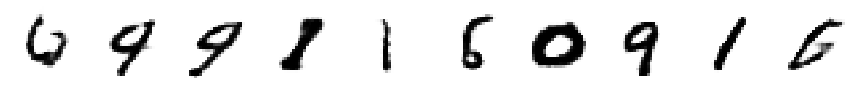

--------------- Epoch 40 ---------------


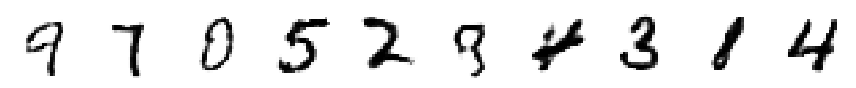

--------------- Epoch 60 ---------------


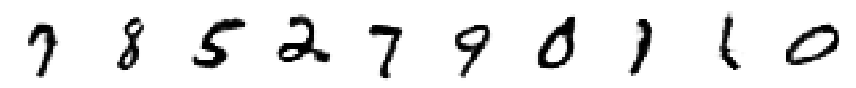

--------------- Epoch 80 ---------------


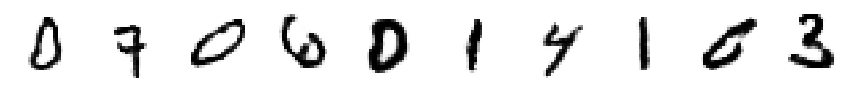

--------------- Epoch 100 ---------------


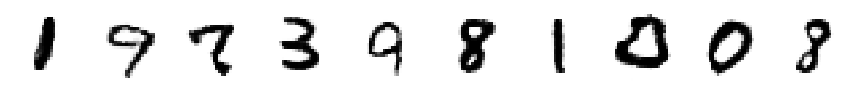

--------------- Epoch 120 ---------------


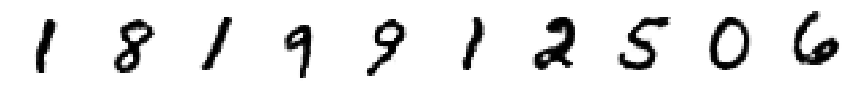

--------------- Epoch 140 ---------------


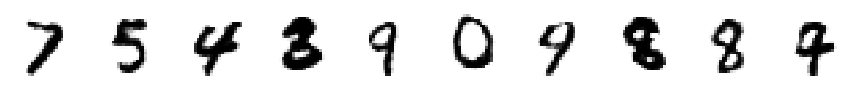

--------------- Epoch 160 ---------------


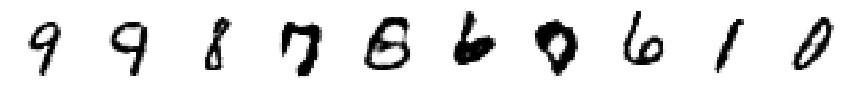

--------------- Epoch 180 ---------------


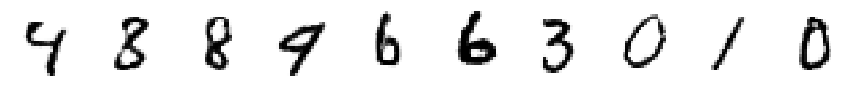

--------------- Epoch 200 ---------------


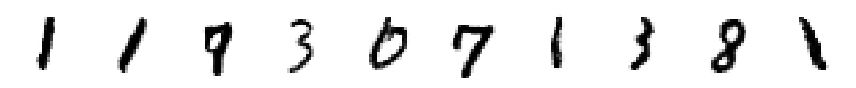

--------------- Epoch 220 ---------------


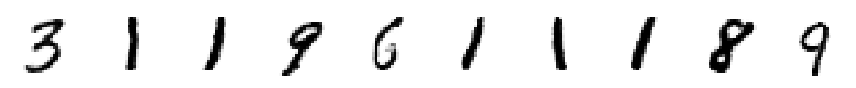

--------------- Epoch 240 ---------------


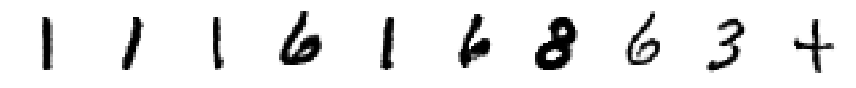

--------------- Epoch 260 ---------------


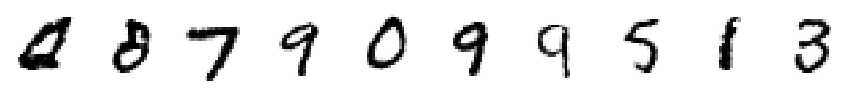

--------------- Epoch 280 ---------------


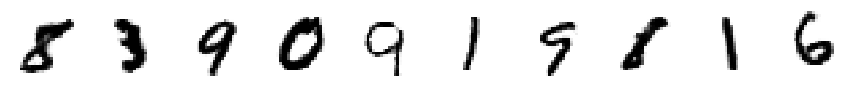

--------------- Epoch 300 ---------------


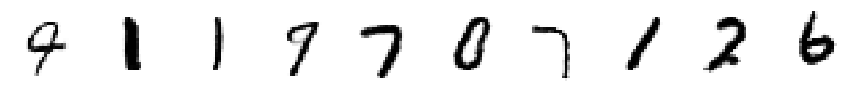

--------------- Epoch 320 ---------------


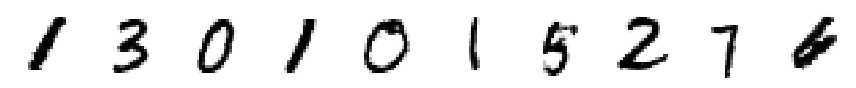

--------------- Epoch 340 ---------------


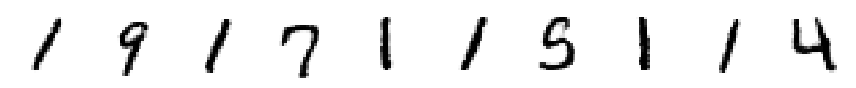

--------------- Epoch 360 ---------------


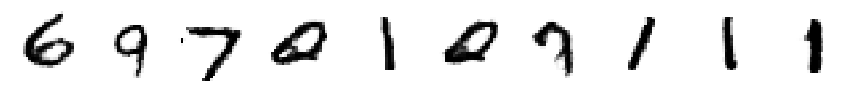

--------------- Epoch 380 ---------------


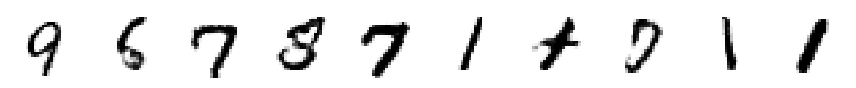

--------------- Epoch 400 ---------------


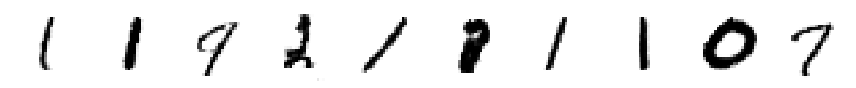

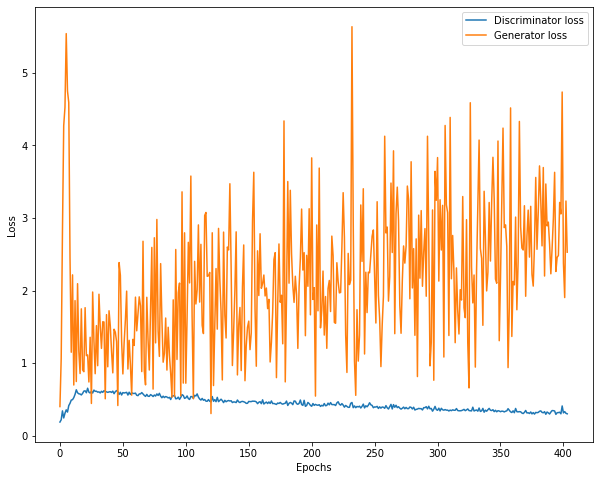

In [19]:
train(epochs=400, plt_frq=20, BATCH_SIZE=512)